## Imports

In [2]:
import argparse
import logging
import os
import torch

import numpy as np
from datasets import load_from_disk
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    BitsAndBytesConfig,
    AutoModel,
    AutoConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
def get_data(lang=None):
    if lang is None:
        return (pd.read_csv('csv_data/train.csv'), 
               pd.read_csv('csv_data/validation.csv'), 
               pd.read_csv('csv_data/test.csv'))
    if lang.lower() == "en-de":
        return (pd.read_csv('csv_data/train.csv').iloc[:6992], 
               pd.read_csv('csv_data/validation.csv').iloc[:1000], 
               pd.read_csv('csv_data/test.csv').iloc[:998])
    elif lang.lower() == "en-zh":
        return (pd.read_csv('csv_data/train.csv').iloc[6992:13964], 
               pd.read_csv('csv_data/validation.csv').iloc[1000:1996], 
               pd.read_csv('csv_data/test.csv').iloc[998:1995])
    elif lang.lower() == "ru-en":
        return (pd.read_csv('csv_data/train.csv').iloc[33898:], 
               pd.read_csv('csv_data/validation.csv').iloc[4842:], 
               pd.read_csv('csv_data/test.csv').iloc[4993:])
    else:
        raise NotImplementedError("Please use a defined language or none")

## Hyperparameters

In [ ]:
lang = "en-de" # either en-de, en-zh, ru-en
batch_size = 16
qlora_enabled = True
learning_rate = 1e-4
num_epochs = 20
patience = 5  # Number of epochs to wait for improvement before stopping
threshold = 0.0005  # Minimum improvement in validation loss

## Set up CometKiwi base model

In [3]:
from comet import download_model, load_from_checkpoint

# Import CometKiwi Model
model_path = download_model("Unbabel/wmt22-cometkiwi-da")
model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/fs/classhomes/fall2024/cmsc723/c7230021/miniconda3/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [4]:
print_trainable_parameters(model)

trainable params: 6296603 || all params: 565137435 || trainable%: 1.114171988978221


## Data Setup

### Import Dataset and Choose Language

In [ ]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

train_df, validation_df, test_df = get_data(lang=lang)

### Normalization for Datasets

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_df['mean'] = scaler.fit_transform(train_df['mean'].values.reshape(-1, 1))
validation_df['mean'] = scaler.transform(validation_df['mean'].values.reshape(-1, 1))
test_df['mean'] = scaler.transform(test_df['mean'].values.reshape(-1, 1))

# Convert the normalized DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

### Tokenize Dataloaders

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")

def tokenize_function(examples):
    return tokenizer(examples["original"], 
        examples["translation"], padding="max_length", truncation=True)

train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
validation_dataset_tokenized = validation_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)
print('Vocab size: ',tokenizer.vocab_size)

Map:   0%|          | 0/6992 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

Vocab size:  105879


In [8]:
# Remove irrelvant columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(['Unnamed: 0','original','translation'])
validation_dataset_tokenized = validation_dataset_tokenized.remove_columns(['Unnamed: 0','original','translation'])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(['Unnamed: 0','original','translation'])

# Rename column names to correct format
train_dataset_tokenized = train_dataset_tokenized.rename_column("mean", "labels")
validation_dataset_tokenized = validation_dataset_tokenized.rename_column("mean", "labels")
test_dataset_tokenized = test_dataset_tokenized.rename_column("mean", "labels")

# Format lists to torch tensors
train_dataset_tokenized.set_format("torch")
validation_dataset_tokenized.set_format("torch")
test_dataset_tokenized.set_format("torch")

# small subset of entire training data for testing the training process

train_dataset_tokenized = train_dataset_tokenized.shuffle(seed=42).select(range(1000))
validation_dataset_tokenized = validation_dataset_tokenized.shuffle(seed=42).select(range(100))
#test_dataset_tokenized = test_dataset_tokenized.shuffle(seed=42).select(range(100))

### Create Torch Dataloaders

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset_tokenized, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(validation_dataset_tokenized, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset_tokenized, batch_size=batch_size)

## Load BERT Model

### Configure Quantization and LoRA

In [ ]:
from transformers import AutoModelForSequenceClassification

qlora_string = "_qlora" if qlora_enabled else "_original"

# bnb_config sets up Quantization
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)
# lora_config sets up LoRA
lora_config = LoraConfig(
    r=16, 
    target_modules = ['query','key','value'],
    inference_mode=False
)

if qlora_enabled:
    bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=1, quantization_config=bnb_config)
    bert_model.gradient_checkpointing_enable()
    print_trainable_parameters(bert_model)
    
    # ADDS Q
    bert_model = prepare_model_for_kbit_training(bert_model)
    
    # ADDS LORA
    bert_model = get_peft_model(bert_model, lora_config)

    print_trainable_parameters(bert_model)
else:
    bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=1)
    print_trainable_parameters(bert_model)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

trainable params: 81748993 || all params: 167357185 || trainable%: 48.84701723442588
trainable params: 884736 || all params: 168241921 || trainable%: 0.5258713136067913


### Set up optimizer, learning rate scheduler, move model to GPU

In [11]:
from torch.optim import AdamW

optimizer = AdamW(bert_model.parameters(), lr=learning_rate)

In [12]:
from transformers import get_scheduler

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [13]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bert_model.to(device);

### Training Loop

In [ ]:
from tqdm.auto import tqdm
import csv
import torch.nn as nn

# Define Mean Squared Error Loss
mse_loss = nn.MSELoss()

# Early stopping variables
best_valid_loss = float('inf')
no_improvement_count = 0

with open(f'loss{qlora_string}_{lang}.csv', 'w', newline='') as f:
   writer = csv.writer(f)
   writer.writerow(['epoch', 'train_loss', 'valid_loss'])
    
# Training Loop
for epoch in range(num_epochs):
    train_losses = []
    valid_losses = []
    
    bert_model.train()
    progress_bar = tqdm(range(len(train_dataloader) + len(eval_dataloader)))
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = bert_model(**batch)
        predictions = outputs.logits.squeeze()  # Ensure predictions are [batch_size]
        loss = mse_loss(predictions, batch["labels"])
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    bert_model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = bert_model(**batch)
            predictions = outputs.logits.squeeze()
            loss = mse_loss(predictions, batch["labels"])
            valid_losses.append(loss.item())
            progress_bar.update(1)
    
    # Compute average losses
    train_loss = sum(train_losses) / len(train_losses)
    valid_loss = sum(valid_losses) / len(valid_losses)
    print(f"Epoch {epoch+1}: Training Loss = {train_loss:.4f}, Validation Loss = {valid_loss:.4f}")
    
    # Log losses
    with open(f'loss{qlora_string}_{lang}.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, train_loss, valid_loss])
    
    # Early stopping logic
    if best_valid_loss - valid_loss > threshold:
        best_valid_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        print(f"No improvement for {no_improvement_count} epoch(s).")
    
    if no_improvement_count >= patience:
        print("Early stopping triggered.")
        break

  0%|          | 0/70 [00:00<?, ?it/s]

/fs/classhomes/fall2024/cmsc723/c7230021/miniconda3/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/fs/classhomes/fall2024/cmsc723/c7230021/miniconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1: Training Loss = 0.6693, Validation Loss = 0.4455


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.1517, Validation Loss = 0.0300


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3: Training Loss = 0.0245, Validation Loss = 0.0237


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4: Training Loss = 0.0187, Validation Loss = 0.0211


  0%|          | 0/70 [00:00<?, ?it/s]

### Bert Model Training Loop

In [ ]:
# save model
#bert_model.save_pretrained(f'Bert{qlora_string}_{lang}.pth')

### Plot train and validation loss graph

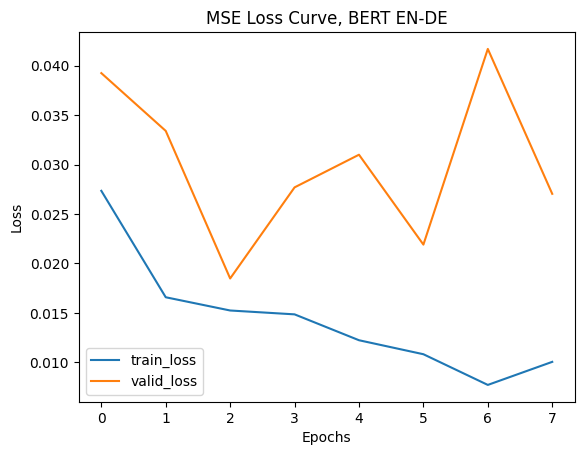

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
train_log = pd.read_csv(f'loss{qlora_string}_{lang}.csv')
train_log[['train_loss', 'valid_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'MSE Loss Curve, BERT{" QLoRA" if qlora_enabled else " "}{lang.upper()}')
#plt.show()
plt.savefig(f'loss{qlora_string}_{lang}.png')

## Run both models on `test.csv`

### CometKiwi model

In [ ]:
test_df["src"] = test_df["original"]
test_df["mt"] = test_df["translation"]
test_input = list(test_df[["src", "mt"]].iloc[i].to_dict() for i in range(test_df.shape[0]))
result = model.predict(test_input, batch_size=batch_size, gpus=1);
comet_kiwi_results = torch.tensor(result.scores, dtype = torch.float32)

/fs/classhomes/fall2024/cmsc723/c7230021/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/fs/classhomes/fall2024/cmsc723/c7230021/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /fs/classhomes/fall2024/cmsc723/c7230021/miniconda3/ ...
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU availa

### Bert Model

In [ ]:
result = []
bert_model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        result.append(bert_model(**batch))
bert_results = torch.cat([i.logits for i in result]).T.squeeze().cpu()

In [ ]:
# Original data
baseline_results = torch.Tensor(test_df["mean"].values)
# Calculate Mean Squared Error on normalized values 
mean_squared_test_error = ((comet_kiwi_results - baseline_results) ** 2).mean().item()
print(f"Mean Squared Test Error CometKiwi predictions(Normalized {lang.upper()}): {mean_squared_test_error}")

Mean Squared Test Error CometKiwi predictions(Normalized EN-DE): 0.014457998797297478


In [ ]:
mean_squared_test_error = ((bert_results - baseline_results) ** 2).mean().item()
print(f"Mean Squared Test Error QLORABERT predictions(Normalized {lang.upper()}): {mean_squared_test_error}")

Mean Squared Test Error QLORABERT predictions(Normalized EN-DE): 0.022732267156243324


QLORABERT predictions were 0.0201.. so it's slightly worse than cometkiwi after training qlorabert

Language, cometkiwi, qlorabert
EN-ZH: 0.026607710868120193, 0.019927382469177246
RU-EN: 0.03764693811535835, 0.046646591275930405

### Spearman Correlation

In [36]:
import scipy.stats as stats

correlation, p_value = stats.spearmanr(baseline_results, bert_results)

print(f'QLORABERT:{lang.upper()}')
print(f"Spearman correlation)", correlation)
print("P-value:", p_value)

QLORABERT:RU-EN
Spearman correlation) 0.5259149313434294
P-value: 3.266896375562134e-72


In [37]:
import scipy.stats as stats

correlation, p_value = stats.spearmanr(baseline_results, comet_kiwi_results)

print(f'QLORABERT:{lang.upper()}')
print(f"Spearman correlation)", correlation)
print("P-value:", p_value)

QLORABERT:RU-EN
Spearman correlation) 0.7565838633110321
P-value: 2.5188016107389757e-186


QLORABERT:RU-EN                                Comet-kiwi
Spearman correlation) 0.5259149313434294       0.7565838633110321
P-value: 3.266896375562134e-72                 2.5188016107389757e-186